In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from tqdm import tqdm
from ast import literal_eval

To get data from all the starwars characters from the official Starwars Databank, we first need to know all the possible URLs to get the data from. This is done by getting the list of all the characters from the 'starwars-databank-server.vercel.app' API:

In [ ]:
URL_CHARACTERS = "https://starwars-databank-server.vercel.app/api/v1/characters"

def getResponse(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to get data. Status code: {response.status_code}")
    data = response.json()
    return data

def cleanString(var):
    return str(var).replace("\"", "\'")

def getNextUrl(data):
    BASE_URL = "https://starwars-databank-server.vercel.app/"
    try: return (BASE_URL + data["info"]["next"])
    except: return None

In [ ]:
character_df_old = None
temp_url = URL_CHARACTERS
character_name_list = []

for _ in tqdm(range(100)):
    data = getResponse(temp_url)
    character_name_list += [cleanString(character["name"]) for character in data["data"]]
    
    # Since the getResponse function doesn't return all characters
    # we need to loop through the different API "pages" with getNextUrl
    temp_url = getNextUrl(data)
    if temp_url is None:
        print("Done!")
        break

url_name_list = ["-".join(name.lower().replace("\'", "").split()) for name in character_name_list]

 96%|█████████▌| 96/100 [00:54<00:02,  1.75it/s]

Done!


Now that we have a list of character names we can then start getting the character data we actually want from the official Star Wars databank website. We achieve this by appending these names to the end of the base URL. From the resulting HTML page we can then extract the desired data:

In [ ]:
BASE_URL = "https://www.starwars.com/databank/"
URL_ADDITIONS = url_name_list

errors = []
number_of_errors = 0

def add_one_error():
    global number_of_errors
    number_of_errors += 1

def get_page(url):
    try: response = requests.get(url)
    except: errors.append(url); add_one_error(); return None
    return BeautifulSoup(response.text, "html.parser")

def check_if_error_404(soup):
    try: soup.find_all("p", class_="desc")[0].text; return False
    except: return True

def get_properties(soup):
    stats = soup.find_all("section", class_="module stats span-full-screen content-span-full-screen secondary-theme dark")
    categories = stats[0].find_all("div", class_="category")
    properties = {}
    for category in categories:
        heading = category.find_all("div", class_="heading")[0].text
        property_names = [p.text for p in category.find_all("div", class_="property-name")]
        properties[heading] = property_names
    return properties

def get_description(soup):
    discription = soup.find_all("p", class_="desc")[0].text
    discription = discription.replace("\n", "")
    return discription

def get_history(soup):
    all_referals = []
    all_text = soup.find_all("div", class_="rich-text-output")
    if len(all_text) == 0:
        return None, None
    minor_text_samples = all_text[0].find_all("p")
    all_history_text = ""
    for sample in minor_text_samples:
        referals = sample.find_all("a")
        for referal in referals:
            all_referals.append(referal.text.strip())
        all_history_text += " " + sample.text
    return all_history_text, all_referals

def get_descriptions(url):
    soup = get_page(url)
    if soup is None or check_if_error_404(soup):
        errors.append(url)
        add_one_error()
        return None
    description = get_description(soup)
    history, referal = get_history(soup)
    properties = get_properties(soup)
    return description, referal, properties, history

#### Getting all the correct URL's before proceeding

In [ ]:
def check_if_working_url(url):
    soup = get_page(url)
    if soup is None or check_if_error_404(soup):
        return False
    return True

In [ ]:
all_urls = []
errors = []

for i in tqdm(range(len(character_name_list))):
    name = character_name_list[i]
    url_addition = URL_ADDITIONS[i]
    full_url = BASE_URL + url_addition
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 964/964 [11:32<00:00,  1.39it/s]


### Concat cleaned errors and all_urls

In [ ]:
potentially_cleaned_urls = []

cleaned_errors = [lst.split("\n") for lst in open("cleaned_errors.csv", "r").readlines()]
for cleaned_error in cleaned_errors:
    potentially_cleaned_urls.append(cleaned_error[0])

In [ ]:
errors = []

for i in tqdm(range(len( potentially_cleaned_urls))):
    name = literal_eval(potentially_cleaned_urls[i])[0]
    full_url = literal_eval(potentially_cleaned_urls[i])[1]
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 68/68 [00:41<00:00,  1.63it/s]


In [ ]:
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(str(line) + "\n")

### Making the dataframe

In [ ]:
# creating dataframe objects:
new_names = []
errors = []
descriptions = []
referals = []
properties = []
histories = []
number_of_errors = 0

for i in tqdm(range(len(all_urls))):
    name = all_urls[i][0]
    full_url = all_urls[i][1]
    descriptions_tuple = get_descriptions(full_url)

    if descriptions_tuple is None:
        continue 
    
    description, referal, property, history = descriptions_tuple
    new_names.append(name)
    descriptions.append(description)
    referals.append(referal)
    properties.append(property)
    histories.append(history)

    all_urls.append((name, full_url))  

print("Number of errors: ", number_of_errors)
print(*errors, sep="\n") 

cleaned_descriptions = [description.replace("\n", "").replace("\r", "") for description in descriptions]
df = pd.DataFrame({"name": new_names, "description": cleaned_descriptions, "referals": referals, "properties": properties, "history": history})
df.to_csv("descriptions.csv", sep=";")

100%|██████████| 958/958 [10:44<00:00,  1.49it/s]

Number of errors:  0



In [ ]:
print("Number of errors: ", number_of_errors)
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(line + "\n")

Number of errors:  0


In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from tqdm import tqdm
from ast import literal_eval

To get data from all the starwars characters from the official Starwars Databank, we first need to know all the possible URLs to get the data from. This is done by getting the list of all the characters from the 'starwars-databank-server.vercel.app' API:

In [ ]:
URL_CHARACTERS = "https://starwars-databank-server.vercel.app/api/v1/characters"

def getResponse(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Failed to get data. Status code: {response.status_code}")
    data = response.json()
    return data

def cleanString(var):
    return str(var).replace("\"", "\'")

def getNextUrl(data):
    BASE_URL = "https://starwars-databank-server.vercel.app/"
    try: return (BASE_URL + data["info"]["next"])
    except: return None

In [ ]:
character_df_old = None
temp_url = URL_CHARACTERS
character_name_list = []

for _ in tqdm(range(100)):
    data = getResponse(temp_url)
    character_name_list += [cleanString(character["name"]) for character in data["data"]]
    
    # Since the getResponse function doesn't return all characters
    # we need to loop through the different API "pages" with getNextUrl
    temp_url = getNextUrl(data)
    if temp_url is None:
        print("Done!")
        break

url_name_list = ["-".join(name.lower().replace("\'", "").split()) for name in character_name_list]

 96%|█████████▌| 96/100 [00:54<00:02,  1.75it/s]

Done!


Now that we have a list of character names we can then start getting the character data we actually want from the official Star Wars databank website. We achieve this by appending these names to the end of the base URL. From the resulting HTML page we can then extract the desired data:

In [ ]:
BASE_URL = "https://www.starwars.com/databank/"
URL_ADDITIONS = url_name_list

errors = []
number_of_errors = 0

def add_one_error():
    global number_of_errors
    number_of_errors += 1

def get_page(url):
    try: response = requests.get(url)
    except: errors.append(url); add_one_error(); return None
    return BeautifulSoup(response.text, "html.parser")

def check_if_error_404(soup):
    try: soup.find_all("p", class_="desc")[0].text; return False
    except: return True

def get_properties(soup):
    stats = soup.find_all("section", class_="module stats span-full-screen content-span-full-screen secondary-theme dark")
    categories = stats[0].find_all("div", class_="category")
    properties = {}
    for category in categories:
        heading = category.find_all("div", class_="heading")[0].text
        property_names = [p.text for p in category.find_all("div", class_="property-name")]
        properties[heading] = property_names
    return properties

def get_description(soup):
    discription = soup.find_all("p", class_="desc")[0].text
    discription = discription.replace("\n", "")
    return discription

def get_history(soup):
    all_referals = []
    all_text = soup.find_all("div", class_="rich-text-output")
    if len(all_text) == 0:
        return None, None
    minor_text_samples = all_text[0].find_all("p")
    all_history_text = ""
    for sample in minor_text_samples:
        referals = sample.find_all("a")
        for referal in referals:
            all_referals.append(referal.text.strip())
        all_history_text += " " + sample.text
    return all_history_text, all_referals

def get_descriptions(url):
    soup = get_page(url)
    if soup is None or check_if_error_404(soup):
        errors.append(url)
        add_one_error()
        return None
    description = get_description(soup)
    history, referal = get_history(soup)
    properties = get_properties(soup)
    return description, referal, properties, history

#### Getting all the correct URL's before proceeding

In [ ]:
def check_if_working_url(url):
    soup = get_page(url)
    if soup is None or check_if_error_404(soup):
        return False
    return True

In [ ]:
all_urls = []
errors = []

for i in tqdm(range(len(character_name_list))):
    name = character_name_list[i]
    url_addition = URL_ADDITIONS[i]
    full_url = BASE_URL + url_addition
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 964/964 [11:32<00:00,  1.39it/s]


### Concat cleaned errors and all_urls

In [ ]:
potentially_cleaned_urls = []

cleaned_errors = [lst.split("\n") for lst in open("cleaned_errors.csv", "r").readlines()]
for cleaned_error in cleaned_errors:
    potentially_cleaned_urls.append(cleaned_error[0])

In [ ]:
errors = []

for i in tqdm(range(len( potentially_cleaned_urls))):
    name = literal_eval(potentially_cleaned_urls[i])[0]
    full_url = literal_eval(potentially_cleaned_urls[i])[1]
    if check_if_working_url(full_url):
        all_urls.append((name, full_url))
    else:
        errors.append((name, full_url))

100%|██████████| 68/68 [00:41<00:00,  1.63it/s]


In [ ]:
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(str(line) + "\n")

### Making the dataframe

In [ ]:
# creating dataframe objects:
new_names = []
errors = []
descriptions = []
referals = []
properties = []
histories = []
number_of_errors = 0

for i in tqdm(range(len(all_urls))):
    name = all_urls[i][0]
    full_url = all_urls[i][1]
    descriptions_tuple = get_descriptions(full_url)

    if descriptions_tuple is None:
        continue 
    
    description, referal, property, history = descriptions_tuple
    new_names.append(name)
    descriptions.append(description)
    referals.append(referal)
    properties.append(property)
    histories.append(history)

    all_urls.append((name, full_url))  

print("Number of errors: ", number_of_errors)
print(*errors, sep="\n") 

cleaned_descriptions = [description.replace("\n", "").replace("\r", "") for description in descriptions]
df = pd.DataFrame({"name": new_names, "description": cleaned_descriptions, "referals": referals, "properties": properties, "history": history})
df.to_csv("descriptions.csv", sep=";")

100%|██████████| 958/958 [10:44<00:00,  1.49it/s]

Number of errors:  0



In [ ]:
print("Number of errors: ", number_of_errors)
with open("errors.csv", "w") as f:
    for line in errors:
        f.write(line + "\n")

Number of errors:  0


In [1]:
import os
import re
import ast
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm

In [2]:
# df = pd.read_csv('Characters.csv')
# names = df['name'].values

In [4]:
df_texts = pd.read_csv('descriptions.csv', sep=';')
texts = df_texts['description'].values
names = df_texts['name'].values
hyper_refs = df_texts['referrals']
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(ast.literal_eval(prop))

In [4]:
adjacency_matrix = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(texts)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            findall = re.findall(nick_name, text)
            text = re.sub(nick_name, '', text)
            count += len(findall)
        counts.append(count)
    # counts = np.array(counts)
    # The row is the node from which the edge comes and the column is thus the receiving node
    # adjacency_matrix[i] += np.array(counts)
    # adjacency_matrix[:, i] += counts.T

958it [00:36, 25.99it/s]


In [5]:
adjacency_matrix_compare = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(hyper_refs)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            count += len(re.findall(nick_name, str(text)))
        counts.append(count)
    # counts = np.array(counts)
    # The row is the node from which the edge comes and the column is thus the receiving node
    adjacency_matrix_compare[i] += np.array(counts)

958it [00:36, 26.10it/s]


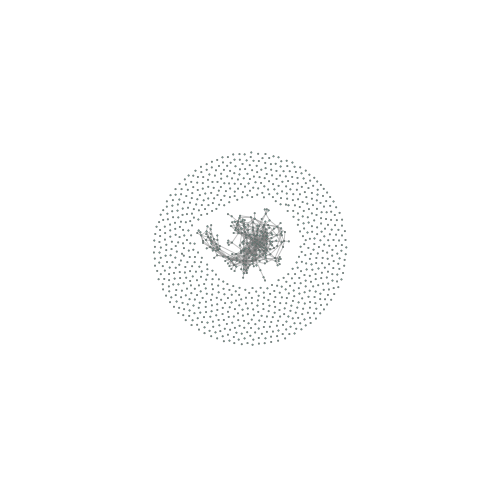

In [6]:
adjacency_matrix += (adjacency_matrix_compare == 1) * (adjacency_matrix == 0)
G = nx.from_numpy_matrix(adjacency_matrix)
network, config = nw.visualize(G, config={'zoom':0.6, 'node charge':-15, 'node gravity': 0.7})
nw.save("Graph.json", network, config, G)

In [11]:
len(G.nodes)

958

In [14]:
stylized_network, config, G = nw.load("Graph.json")

This next part does some basic analysis

Maximum degree: 68, Minimum degree: 0
Assortivity coefficient r = 0.007


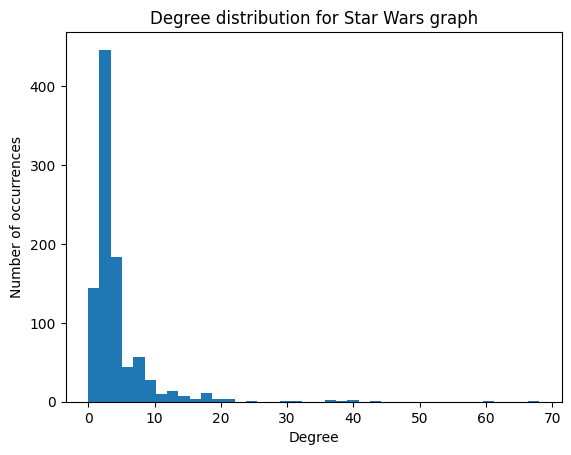

In [29]:
import matplotlib.pyplot as plt
degrees = [d for _, d in G.degree()]

print(f'Maximum degree: {max(degrees)}, Minimum degree: {min(degrees)}')
r = nx.degree_assortativity_coefficient(G)
print(f"Assortivity coefficient r = {r:.3f}")
plt.hist(degrees, bins=40)
plt.title('Degree distribution for Star Wars graph')
plt.ylabel('Number of occurrences')
plt.xlabel('Degree')
plt.savefig('DegreeDistribution.png')
plt.show()

In [21]:
connected_largest = sorted(nx.algorithms.connected_components(G), key=len, reverse=True)[0]
G_sub = nx.Graph.subgraph(G, connected_largest)
avg_shortest_sub = nx.average_shortest_path_length(G_sub)
print(f'Average shortest path in the largest connected component is {round(avg_shortest_sub, 2)}')

Average shortest path in the largest connected component is 4.63


In [ ]:
fig, ax = nw.draw_netwulf(network)
plt.savefig('StarWarsGraphNaked')

In [5]:
# Compute the communities
partition = nx_comm.louvain_communities(G)
# Create a list of the number of nodes in each community
sizes = [len(c) for c in partition]
print(
    f'The average community size is {round(np.mean(sizes), 2)}, with a standard deviation of {round(np.std(sizes), 2)}. The largest is of size {np.max(sizes)} and the smallest {np.min(sizes)}')

NameError: name 'G' is not defined

In [ ]:
# Create a np array of nodes to use for finding their positions in the graph's list
G_where = np.array(G.nodes)
# Initialize the array for colours and the values for which to colour
degreeColor = np.empty(len(G_where), dtype=object)
valueToPlot = np.log10(sizes)
# we rescale the colours to be in the RGB format (0 to 255 for three colours)
valueToPlotRescaled = 255*(valueToPlot - np.min(valueToPlot))/np.max(valueToPlot)

for size, c in zip(sizes, partition):
    for node in c:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % (int(size), 0, 50)
        degreeColor[np.where(G_where == node)] = color
# zip it up into a dictionary and set it as node attribute
dictionaryColor = dict(zip(list(G.nodes), degreeColor))
nx.set_node_attributes(G, dictionaryColor, 'group')

In [ ]:
def modularity(G, communities):
    m = G.number_of_edges()
    q = .0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc / m - (kc / (2 * m)) ** 2
    return q

modularity_from_current_communities = modularity(G, partition)

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

# Getting tokens

To tokenize the descriptions we'll need a function that tokenizes a string and removes undesired words and characters. We'll use the NLTK library for this.

In [12]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()


# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit(): # Remove digits
                continue
            elif token in punctuation or token in ["'s","’",".","--"] or token in stopwords: # Remove punctuation and stopwords
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

With this get_tokens function it's now possible to get the tokens, but unfortunately the returned words are stemmed which doesn't look nice and is only relevant for getting the TF-IDF of unique words. And since we still want to be able to display some beautiful Wordclouds with actual words that match (as best as possible) the original words we therefore choose the most frequent and therefore most likely original version of the stemmed word, and replace it with that.

In [3]:
import pandas as pd
from ast import literal_eval

from collections import defaultdict, Counter
from statistics import mode


# Loading the descriptions dataset:
character_data = pd.read_csv('ProjectA/descriptions.csv', sep=";", usecols=[1, 2, 3, 4, 5], converters={4: literal_eval})
character_data.set_index("name", inplace=True)
character_data = character_data.sort_index()

# Tokenizing the entire corpus:
star_wars_vocab = word_tokenize(" ".join(character_data["description"]).lower())
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# Adding the tokens column to the dataset:
character_data["tokens"] = character_data["description"].apply(get_tokens).apply(lambda tokens: list(map(token_beautifier, tokens)))
character_data = character_data[["description", "tokens", "properties", "referrals", "history"]]

# Optionally saving the dataset:
# character_data.to_csv("ProjectA/descriptions_tokens.csv", sep=";")

# Getting character groups

To get the different desired groupings we create a defaultdict and iterate over the properties of each character, choosing the first in that list of properties as the main property. Simply choosing the first of many possiple items in a list of properties might be a bit arbitrary, but it's the best we can do for now.

In [7]:
def get_groups(property_choice, character_data=character_data):
    errors = 0
    groups_dict = defaultdict(list)
    for i in range(len(character_data)):
        character = character_data.iloc[i]
        character_prop = character["properties"]
        try:
            prop = character_prop[property_choice][0]
        except:
            errors += 1
            continue
        groups_dict[prop].append(i)

    print(f'This many characters {errors}, do not have the property: {property_choice}.')
    character_groups = [character_data.iloc[group] for group in list(groups_dict.values())]
    return character_groups

# Calculating TF-IDF

To create the TF-IDF word-frequency-dictionary for each group we first calculate the IDF of the whole corpus. Then we iterate over each group and each word in that group, adding the calculated TF-IDF for each word to the "word-frequency-dictionary".

In [9]:
import numpy as np

# TF and IDF formulas:
IDF = lambda term_count: np.log10(len(character_data) / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum(character_data["tokens"].apply(set).apply(list), [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

# Function to calculate the word-frequency-dictionaries for each group in a list of communities:
def get_TF_IDF(communities, single=False):
    if single: communities = [communities]
    
    community_TF_IDF = []
    for group in communities:
        group_total_tokens = sum(group["tokens"], []) # Adding all tokens of the group together.
        group_total_tokens_count = Counter(group_total_tokens)
        
        # Calculating the TF-IDF and making it into a dictionary:
        tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
        community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
    if single: return community_TF_IDF[0]
    return community_TF_IDF

# An extra function to combine the dictionaries of multiple communities into one
# for example with the purpose of making a wordcloud of all the groups:
def combine_dictionaries(dictionaries):
    combined_dict = {}
    counts = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in combined_dict:
                combined_dict[key] = value
                counts[key] = 1
            else:
                combined_dict[key] += value
                counts[key] += 1
    for key in combined_dict:
        combined_dict[key] /= counts[key]
    
    return dict(sorted(combined_dict.items(), key=lambda item: item[1], reverse=True))

# Making wordclouds

To create the wordclouds we use the wordcloud library where we've chosen to include a Star Wars font and a relevant background image-mask of the Death Star. Furthermore we've chosen to color the words according to their TF-IDF score, and to make the wordclouds more readable we've chosen not to include words that are too small (in terms of font-size which is of course affected by TF-IDF).

In [10]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image


def create_wordcloud(word_frequency_dict):
    # The backgroud mask for the wordcloud:
    sw_mask = np.array(Image.open("ProjectA/images_wordclouds/death_star1.png").convert('RGB'))
    
    # The color function to decide how words are colored:
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return f"hsl(0, 0%, {font_size * 0.7 + 30}%)"

    # The wordcloud itself, with the mask, color function, and other parameters included:
    wordcloud = WordCloud(
        font_path="ProjectA/images_wordclouds/StarJedi.ttf", background_color="black",
        width=600, height=600, max_words=400, min_font_size=9, max_font_size=100,
        mask=sw_mask).generate_from_frequencies(word_frequency_dict)
    wordcloud = wordcloud.recolor(color_func=grey_color_func, random_state=3)

    # Finally plotting the wordcloud:
    plt.figure( figsize=(20,10), facecolor='k' );
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis("off");

This many characters 86, do not have the property: Appearances.

Word Cloud for Star Wars: Return of the Jedi (Episode VI):


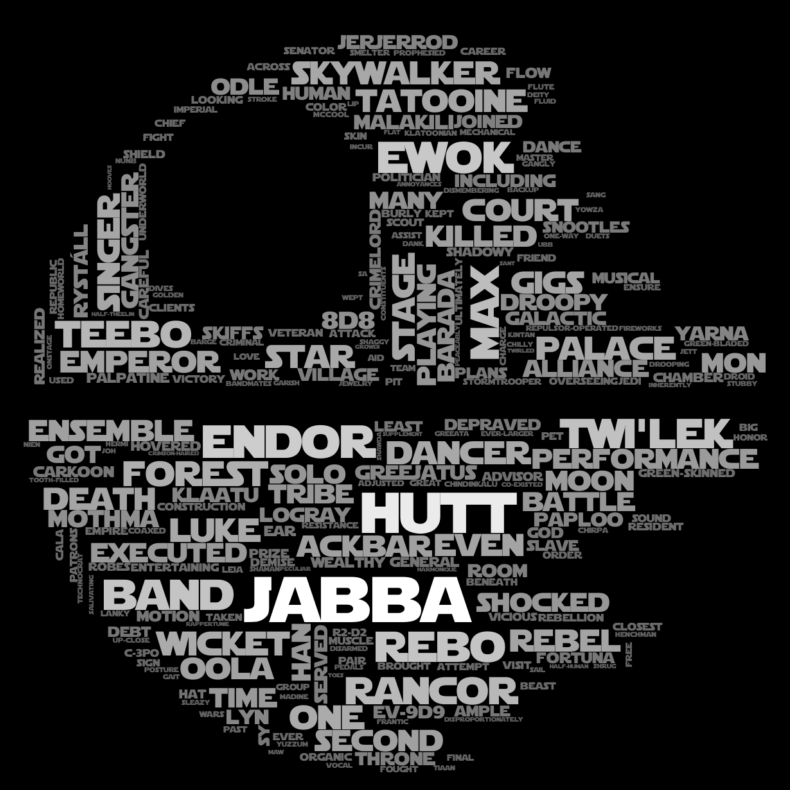

In [11]:
property_choice = "Appearances"
character_groups = get_groups(property_choice)

group_idx = 3
print(f"\nWord Cloud for {character_groups[group_idx]['properties'][0][property_choice][0]}:")

create_wordcloud(get_TF_IDF(character_groups[group_idx], single=True))

In [1]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [2]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [3]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [4]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [5]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [6]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  212
Number of links for Episode V:  145
Number of links for Episode VI:  152


In [7]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  509


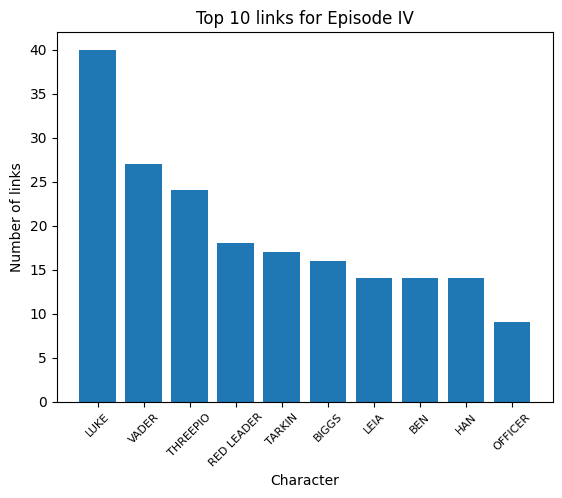

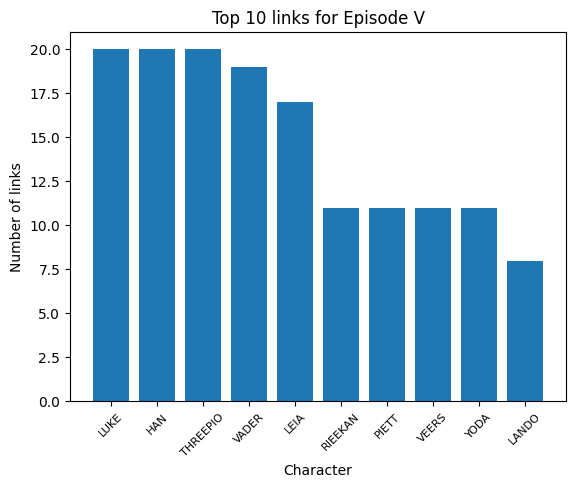

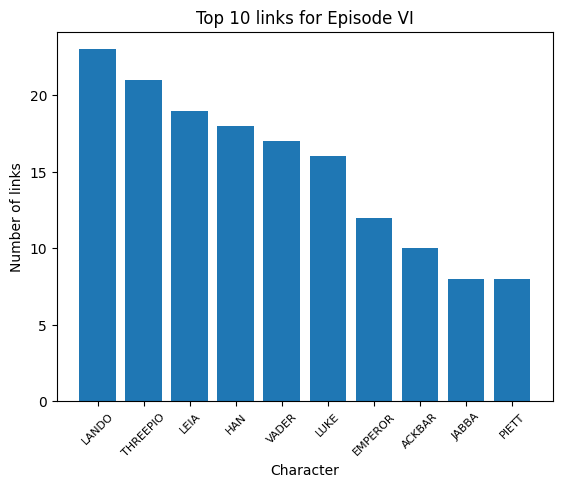

In [8]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time:

In [51]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        all_nodes.append(nodes_for_each_ep[:])
        all_links.append(links_for_each_ep[:])
    print("Nodes: ", [len(node) for node in all_nodes])
    print("Links: ", [len(link) for link in all_links])
    return all_nodes, all_links

def number_of_links_lst(all_nodes, all_links):
    return [len(node) for node in all_nodes], [len(link) for link in all_links]

In [52]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos=pos, with_labels=True, font_size = 5, ax=axs[i])
        #plt.title(f"Episode {i+4}")
        #plt.show()
        axs[i].set_title(f'Episode {i+1}')

nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)
print(*[(len(node), len(link)) for node, link in zip(nodes_for_each_ep, links_for_each_ep)], sep="\n")

Nodes:  [45, 66, 82]
Links:  [45, 66, 82]
(45, 45)
(66, 66)
(82, 82)


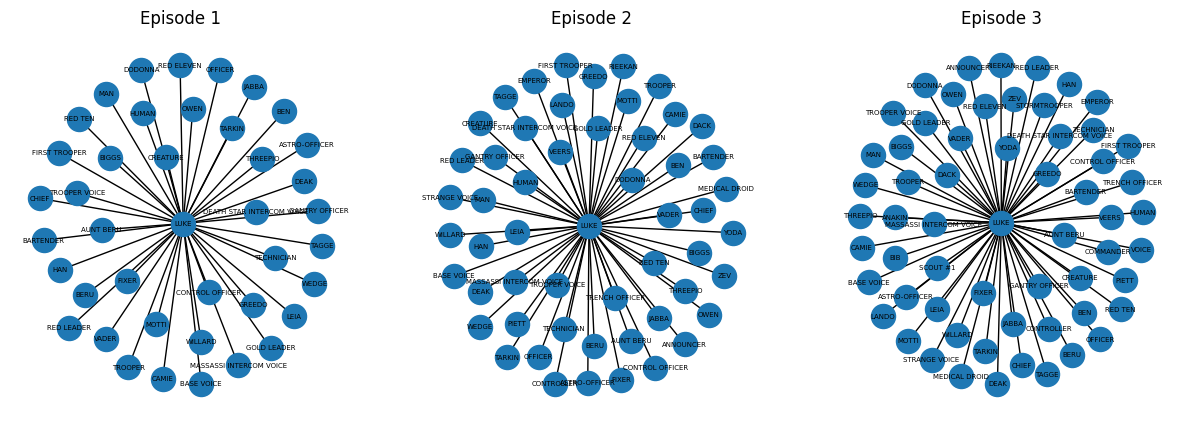

In [54]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
luke_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

We will now replicate for Threepio:

Nodes:  [32, 58, 84]
Links:  [32, 58, 84]


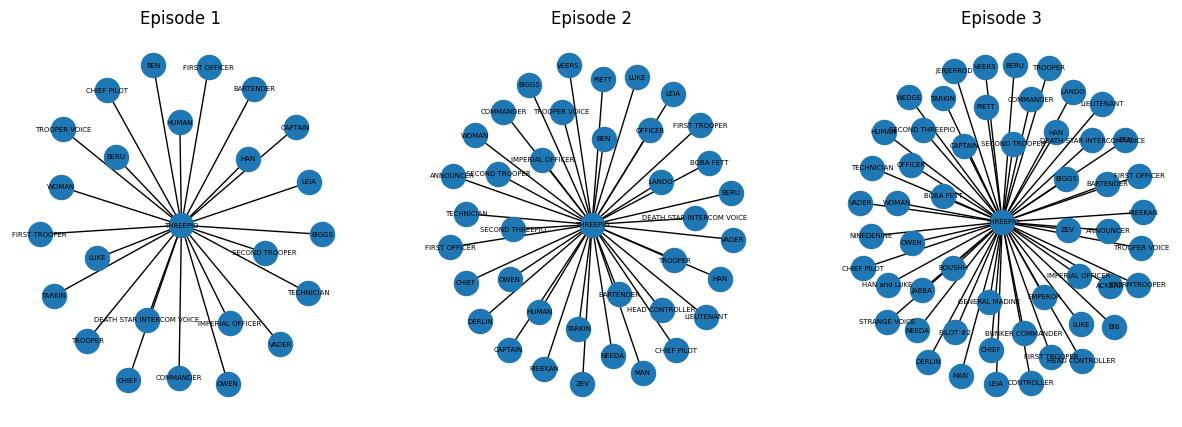

In [57]:
nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("threepio", links)
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)
threepio_len = number_of_links_lst(nodes_for_each_ep, links_for_each_ep)

Here it is obvious that both Luke and C-3PO (ThreePio) develop a 

In [65]:
def procent_rise(args):
    nodes, links = args
    nodes_percentage = [round((node - nodes[0])/nodes[0]*100, 4) for node in nodes]
    links_percentage = [round((link - links[0])/links[0]*100, 4) for link in links]
    print("Rise in nodes: ", nodes_percentage)
    print("Rise in links: ", links_percentage)
    return nodes_percentage, links_percentage

print("Luke: ")
procent_rise(luke_len)
print("\nThreepio: ")
procent_rise(threepio_len)

Luke: 
Rise in nodes:  [0.0, 46.6667, 82.2222]
Rise in links:  [0.0, 46.6667, 82.2222]

Threepio: 
Rise in nodes:  [0.0, 81.25, 162.5]
Rise in links:  [0.0, 81.25, 162.5]


([0.0, 81.25, 162.5], [0.0, 81.25, 162.5])

## Word Frequency

In [66]:
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [69]:
dialogues = [ep["dialogue"].values for ep in cleaned_episodes]
dialogues[0]

array(["Did you hear that?  They've shut down the main reactor.  We'll be destroyed for sure.  This is madness!",
       "We're doomed!",
       "There'll be no escape for the Princess this time.", ...,
       "We'll get to work on him right away.",
       "You must repair him!  Sir, if any of my circuits or gears will help, I'll gladly donate them.",
       "He'll be all right."], dtype=object)

In [82]:
!pip3 install nltk

In [85]:
import collections
import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasvilsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
texts = [(" ".join(dialogue)).lower() for dialogue in dialogues]

6
5
3


/var/folders/pl/7f1cr2657p3bnpdt3bnm_9w00000gn/T/ipykernel_57101/3317700052.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(common_words, rotation=45)


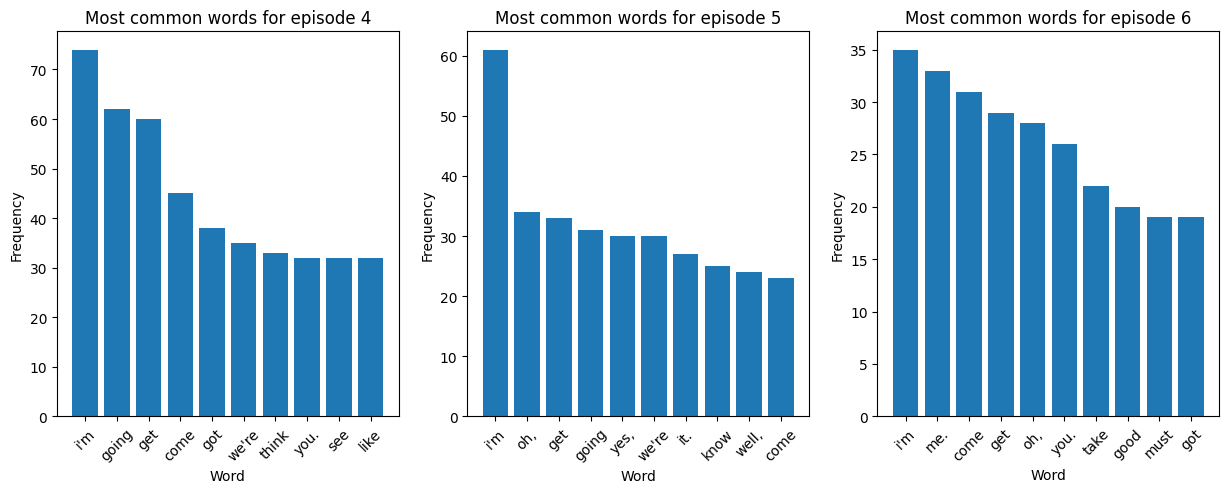

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

def count_words(text):
    word_counts = {}
    for word in text.split():
        if word not in stopwords:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    return word_counts

for i, text in enumerate(texts):
    word_count = count_words(text)
    print(word_count["luke"])
    word_count = collections.Counter(word_count)
    common_words = [word for word, counter in word_count.most_common(10)]
    word_freq = [counter for word, counter in word_count.most_common(10)]

    axs[i].bar(common_words, word_freq)
    axs[i].set_title(f"Most common words for episode {i+4}")
    axs[i].set_xlabel("Word")
    axs[i].set_xticklabels(common_words, rotation=45)
    axs[i].set_ylabel("Frequency")

In [ ]:
import collections
import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasvilsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
import os
import ast
import re
from ast import literal_eval
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm
import colorsys
import random

In [2]:
# Load the network
df_texts = pd.read_csv('descriptions.csv', sep=';', converters={'properties': literal_eval})
stylized_network, config, G = nw.load("Graph.json")

In [3]:
# Create a dictionary and list in the format used by the functions
def return_set():
    return set()
def return_list():
    return []
properties_dict = defaultdict(return_set)
for dic in df_texts['properties']:
    for el in dic.keys():
        for el1 in dic[el]:
            properties_dict[el].add(el1)
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(prop)

In [4]:
def generate_colors(n):
    # Set the number of color hues to evenly space the colors
    hue_values = [i/n for i in range(n)]
    saturation = 0.5
    value = 0.95

    # Convert the HSV color values to RGB format and store them in a list
    colors = []
    for hue in hue_values:
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        r, g, b = int(r * 255), int(g * 255), int(b * 255)
        colors.append((r, g, b))

    # Shuffle the list to randomize the order of colors
    random.shuffle(colors)

    return colors

def graph_with_grouping(properties_dict, attribute, properties_list, Graph, return_communities=False):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(possible_values))
    color_dict = {key: value for key, value in zip(possible_values, colors_avail)}
    color_list = []
    communities = defaultdict(return_list)

    for props, node in zip(properties_list, Graph.nodes):
        # Use the size to set the colour
        
        if attribute in props.keys():
            communities[props[attribute][0]].append(node)
            color = '#%02x%02x%02x' % color_dict[props[attribute][0]]
        else:
#             communities[None].append(node)
            color = '#%02x%02x%02x' % (150, 150, 150)
        color_list.append(color)
        
    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')
    
    if return_communities:
        communities = [val for val in communities.values()]
        return Graph, communities
    return Graph

def graph_with_louvain(Graph, communities):
    """
    Given the dictionay of properties and the property/attribute
    of interest, along with the list of properties ordered by
    node, return the graph with randomised colors.
    If return_communities, it will return a list of lists of
    communities
    :param properties_dict:
    :param attribute:
    :param Graph:
    :return:
    """
    from copy import deepcopy

    Graph = deepcopy(Graph)
    # possible_values = properties_dict[attribute]
    colors_avail = generate_colors(len(communities))
    color_dict = {}

    for com_set, color in zip(communities, colors_avail):
        for val in com_set:
            color_dict[val] = color

    color_list = []
    for node in Graph.nodes:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % color_dict[node]
        color_list.append(color)

    # zip it up into a dictionary and set it as node attribute
    dictionaryColor = dict(zip(list(Graph.nodes), color_list))
    nx.set_node_attributes(Graph, dictionaryColor, 'group')

    return Graph

def modularity(G, communities):
    m = G.number_of_edges()
    q = .0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc / m - (kc / (2 * m)) ** 2
    return q

The following section create the clusterings based on each attribute and visualise them using netwulf.

In [ ]:
for attribute in properties_dict.keys():
    G1, communities = graph_with_grouping(properties_dict, attribute, properties_list, G, return_communities=True)
    network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
    nx.draw(G1)
    # nw.save(f"Graph_{attribute}.json", network, config, G1)
    plt.savefig(f"Graph_{attribute}.png")
    print(f"{attribute} has modularity: {modularity(G1, communities)}")

Appearances has modularity: 0.3005900808653643


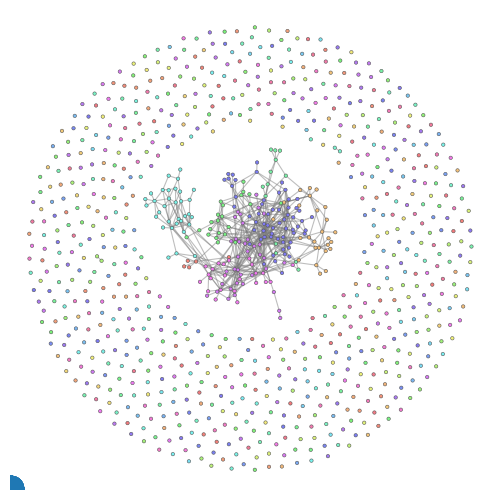

In [8]:
partition = nx_comm.louvain_communities(G)
G1 = graph_with_louvain(G, partition)
network, config = nw.visualize(G1, config={'zoom':0.73, 'node charge':-15, 'node gravity': 0.7, 'post to python': True})
nx.draw(G1)
plt.savefig(f"Graph_louvain.png")
print(f'Louvain groups have modularity {modularity(G1, partition)}')

There is a huge number of nodes that have no links to any other node. This is to be expected due to the nature of characters in the expanded universe of Star Wars. Many characters are introduced in obscure media such as books that few people read, and thus our source does not have much to say about them, leading to no connections.

The bi-directionality of the graph does lead to some loss of information as the nature of the edges is a mention in one article of the other. However, we decided that such a connection should be a between both character as there were so few connections in the entire graph. We did consider using other sources to add nodes to the graph,